## Install dependencies

In [ ]:
%pip install tqdm
%pip install pandas
%pip install ipywidgets
%pip install matplotlib
%pip install serial
%pip install pyubx2
%pip install ecdsa
%pip install hmac
%pip install ntplib
%pip install astropy

In [1]:
from serial import Serial
from pyubx2 import UBXReader,UBXMessage
import csv
import numpy as np
import pandas as pd
from astropy.coordinates import EarthLocation, SkyCoord
from astropy import units as u
# Plotting and interactive packages
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
# Cryptographic packages
from hashlib import sha256
import ecdsa
import hmac
import base64
import socket
# Append osnma folder
import sys
import os
sys.path.append(os.path.abspath("C:/Users/A413626/Desktop/GNSS_stuff/GNSS_Binary/OSNMA_Ublox"))
# Load internal functions
import signal_process
import OSNMA
import time_mangement

%cd C:\Users\A413626\Desktop\GNSS_stuff\GNSS_Binary
record = True #if True we will save the recorded data (e.g., for future playback)
record_filename = '06-04-2022_0.csv'
dump=True
# U-blox chip configurations
COMPort = 'COM4'
boudRate = 38400

# List of u-blox confiugration options and key value
cfgData = [("CFG_ITFM_ENABLE", 1),("CFG_ITFM_ANTSETTING", 2),("CFG_NMEA_PROTVER", 42),
 ("CFG_MSGOUT_NMEA_ID_GBS_USB", 1),("CFG_MSGOUT_UBX_MON_RF_USB", 1),("CFG_MSGOUT_UBX_MON_SPAN_USB", 1),
 ("CFG_MSGOUT_UBX_NAV_CLOCK_USB", 1),("CFG_MSGOUT_UBX_NAV_PVT_USB", 1),("CFG_MSGOUT_UBX_NAV_SIG_USB", 1),
 ("CFG_MSGOUT_UBX_NAV_TIMEGAL_USB", 1),("CFG_MSGOUT_UBX_RXM_RAWX_USB", 1),("CFG_MSGOUT_UBX_NAV_STATUS_USB", 1),
 ("CFG_MSGOUT_UBX_RXM_SFRBX_USB", 1),
 ("CFG_SIGNAL_GLO_ENA", 0), ("CFG_SIGNAL_QZSS_ENA", 0),("CFG_SIGNAL_BDS_ENA", 0),("CFG_SIGNAL_SBAS_ENA", 0)
 ]
# Write to RAM
layers = 1
# No transaction response
transaction = 0
# Create configuration message
config_msg = UBXMessage.config_set(layers, transaction, cfgData)
# Stored msg types  # Talker ID GNGGA , GN =any combo, GP = GPS, GA = Galileo
msg_types = [
 '<NMEA(GAGSV', '<NMEA(GNGBS', ['<NMEA(GNGGA','<NMEA(GAGGA','<NMEA(GPGGA'],
 '<NMEA(GNGLL', '<NMEA(GNVTG', '<NMEA(GPGSV',
 '<UBX(MON-RF', '<UBX(MON-SPAN', '<UBX(NAV-CLOCK', 
 '<UBX(NAV-PVT', '<UBX(NAV-SIG', '<UBX(NAV-TIMEGAL',
 '<UBX(RXM-RAWX', '<UBX(NAV-STATUS', '<UBX(RXM-SFRBX']

# Load processed u-blox csv data from specified file
def load_data (testData):
 # Initialize lists to store messages
 mesages=[]
 msg_collection = [[] for _ in range(len(msg_types))]
 with open(testData) as csvfile:
   parsed_data = csv.reader(csvfile, delimiter=',')
   for row in parsed_data:
     mesages.append(row[0])
     # Check all message types for match
     for i in range(len(msg_types)):
       if row[0] in msg_types[i]:
         if row[0] == '<UBX(RXM-SFRBX' and ' galTow' not in row[2]:
           # Add TOW for sub-frame data
           galileo_time=msg_collection[11][-1][2]
           row.insert(2,galileo_time)
         # Add message to its type list
         msg_collection[i].append(row)
   csvfile.close()
 return  msg_collection, mesages

C:\Users\A413626\Desktop\GNSS_stuff\GNSS_Binary


## Run OSNMA + Time Handler

In [2]:
import importlib
importlib.reload(OSNMA)
importlib.reload(time_mangement)
importlib.reload(signal_process)


# Input file
#testData = '31-03-2022_osnma_spoofing.csv'
testData = '01-04-2022_0_drive.csv'
#testData = '01-04-2022_0_drive.csv'

# Load data
msg_collection, mesages= load_data(testData)
#msg_collection[14] = msg_collection[14][0:1650]
# Read last signal
signal_info = signal_process.read_live_data(msg_collection)
# Run OSNMA on last 4000 pages
osnma_instance, osnma_results = OSNMA.run_osnma(msg_collection,num=15000)
# Get duration and run time handler
osnma_duration = osnma_instance.get_duration()[0]
time_instance, df, time_info,time_fig = time_mangement.run_time(osnma_instance,msg_collection,max_dur=osnma_duration,plot=False)
# Print result
plt.show()
print(signal_info)
print(osnma_results)
print(time_info)

 [' agcCnt_01=5967', ' agcCnt_01=5967', ' agcCnt_01=5967', ' agcCnt_01=5967', ' agcCnt_01=5967'] 
 [' jamInd_01=11', ' jamInd_01=10', ' jamInd_01=11', ' jamInd_01=14', ' jamInd_01=12']
 [' jammingState_01=1', ' jammingState_01=1', ' jammingState_01=1', ' jammingState_01=1', ' jammingState_01=1']
 [' spoofDetState=1', ' spoofDetState=1', ' spoofDetState=1', ' spoofDetState=1', ' spoofDetState=1']
 [' clkB=222841', ' clkB=221919', ' clkB=220997', ' clkB=220075', ' clkB=219152']
 Time: 477753,  iTOW=12:42:15
 Position: lat=57.70390483 lon=11.87836583
 
Average CNO (L1): 42.5
Average Lock duration (L1): 11595.0

Satellites Connected:['GPS, 22', 'Galileo, 20']
 Of which L1/E1: ['GPS, 12', 'Galileo, 10']

Filtering (split): Kept 9840/12200 pages, 80.66%
Filtering (osnma): Kept 4440/9840 pages, 45.12%
Found OSNMA Satellite!
['01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '0

## Real-Time Loop


Main code Loop

In [ ]:
#%cd C:\Users\A413626\Desktop\GNSS_stuff\GNSS_Binary\21-03-2022_data
for run in range(1):
  #record_filename = '21-03-2022_'+str(run)+'.csv'

  mesages=[]
  msg_collection = [[] for _ in range(len(msg_types))]
  galileo_time = " galTow=0"
  # Make sure chip is not being used
  try:
    stream.close()
  except:
    closed=True

  #Num messages to record
  num = 60000
  max_keep=10000
  # Start progress bar
  msg_bar = tqdm(total=num)
  # Start text dump area
  textbox = widgets.Textarea(layout=widgets.Layout(width='50%', height='240px'))
  textbox_OSNMA = widgets.Textarea(layout=widgets.Layout(width='50%', height='350px'))
  display(textbox,textbox_OSNMA)
  # Open stream to u-blox
  stream = Serial(COMPort, boudRate, bytesize=8, parity='N', stopbits=1,)
  # Send configuration message
  stream.write(config_msg.serialize())
  # Read stream
  ubr = UBXReader(stream)
  while(len(mesages)<num):
    (raw_data, parsed_data) = ubr.read()
    if parsed_data is not None:
      ubxPages_new = str(parsed_data).split(",")
      mesages.append(ubxPages_new[0])
      msg_bar.update(1)
      # Check all message types for match
      for i in range(len(msg_types)):
          if ubxPages_new[0] in msg_types[i]:
            if ubxPages_new[0] == '<UBX(RXM-SFRBX':
              # Add galileo time for OSNMA if availble
              galileo_time = msg_collection[11][-1][2] if len(msg_collection[11][-1:]) else " galTow=0"
              ubxPages_new.insert(2,galileo_time)
            # Add message to its type list
            msg_collection[i].append(ubxPages_new)
            msg_collection[i] = msg_collection[i][-max_keep:]
      # Log raw data for later
      if record:
        with open(record_filename, 'a', newline='') as f:
            write = csv.writer(f)
            write.writerow(ubxPages_new)
            f.close()
      if dump and (len(msg_collection[12])>5):
        data_dump_str=signal_process.read_live_data(msg_collection)
        textbox.value=data_dump_str+"\nNumber of Messages: {}".format(len(msg_collection[8]))
        # Check OSNMA every 10 seconds after 100 seconds
        gal_time=int(galileo_time.split('=')[1])
        if gal_time%10==0 and len(msg_collection[14])>50:
          osnma_info = ''
          #osnma_instance,osnma_info = run_osnma(msg_collection)
          textbox_OSNMA.value = osnma_info
  stream.close()
  print("Got the following messages:")
  for i in range(len(msg_collection)):
    print(i,msg_types[i],len(msg_collection[i]))

  0%|          | 0/60000 [00:00<?, ?it/s]

Textarea(value='', layout=Layout(height='240px', width='50%'))

Textarea(value='', layout=Layout(height='350px', width='50%'))

SerialException: could not open port 'COM4': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)

In [ ]:
stream.close()

## View messages received

In [409]:
print("Got the following messages:")
for i in range(len(msg_collection)):
  print(i,msg_types[i],len(msg_collection[i]))

Got the following messages:
0 <NMEA(GAGSV 0
1 <NMEA(GNGBS 0
2 ['<NMEA(GNGGA', '<NMEA(GAGGA', '<NMEA(GPGGA', '$GPGGA'] 4390
3 <NMEA(GNGLL 0
4 <NMEA(GNVTG 0
5 <NMEA(GPGSV 0
6 <UBX(MON-RF 0
7 <UBX(MON-SPAN 0
8 <UBX(NAV-CLOCK 0
9 <UBX(NAV-PVT 0
10 <UBX(NAV-SIG 0
11 <UBX(NAV-TIMEGAL 0
12 <UBX(RXM-RAWX 0
13 <UBX(NAV-STATUS 0
14 <UBX(RXM-SFRBX 0


In [ ]:
# Look for new messages
msg_df=pd.DataFrame(mesages)
msg_df.columns=['msg']
df_split=msg_df.groupby("msg")
df_groups=df_split["msg"].count()
msg_types_found=list(df_groups.index)
msg_types_found
for i in range(len(msg_collection)):
  print(i,msg_types[i],len(msg_collection[i]))
msg_types_found

## Create Position Log

In [3]:
pos_df = signal_process.get_pos_log(msg_collection)
auth_pos_df= signal_process.auth_positions (pos_df,osnma_instance)
#auth_pos_df = auth_pos_df.set_index('Time')
auth_pos_df


,Time,Lat,Lon,Alt,Travelled [m],Duration [sec],Velocity [km/h]
51,476192,57.720062,11.955703,3.7,0.000000,0,NaN
141,476282,57.720742,11.946056,1.5,577.106461,90,23.084258
171,476312,57.720745,11.945950,1.1,6.347201,30,0.761664
201,476342,57.720783,11.941715,6.3,251.218611,30,30.146233
231,476372,57.720908,11.935488,12.5,369.636309,30,44.356357
261,476402,57.720687,11.934144,13.1,83.403953,30,10.008474
291,476432,57.719602,11.927600,14.0,406.365992,30,48.763919
321,476462,57.718675,11.921315,17.9,386.738108,30,46.408573
351,476492,57.718089,11.916837,21.2,273.523157,30,32.822779
381,476522,57.716957,11.910169,21.6,414.928411,30,49.791409


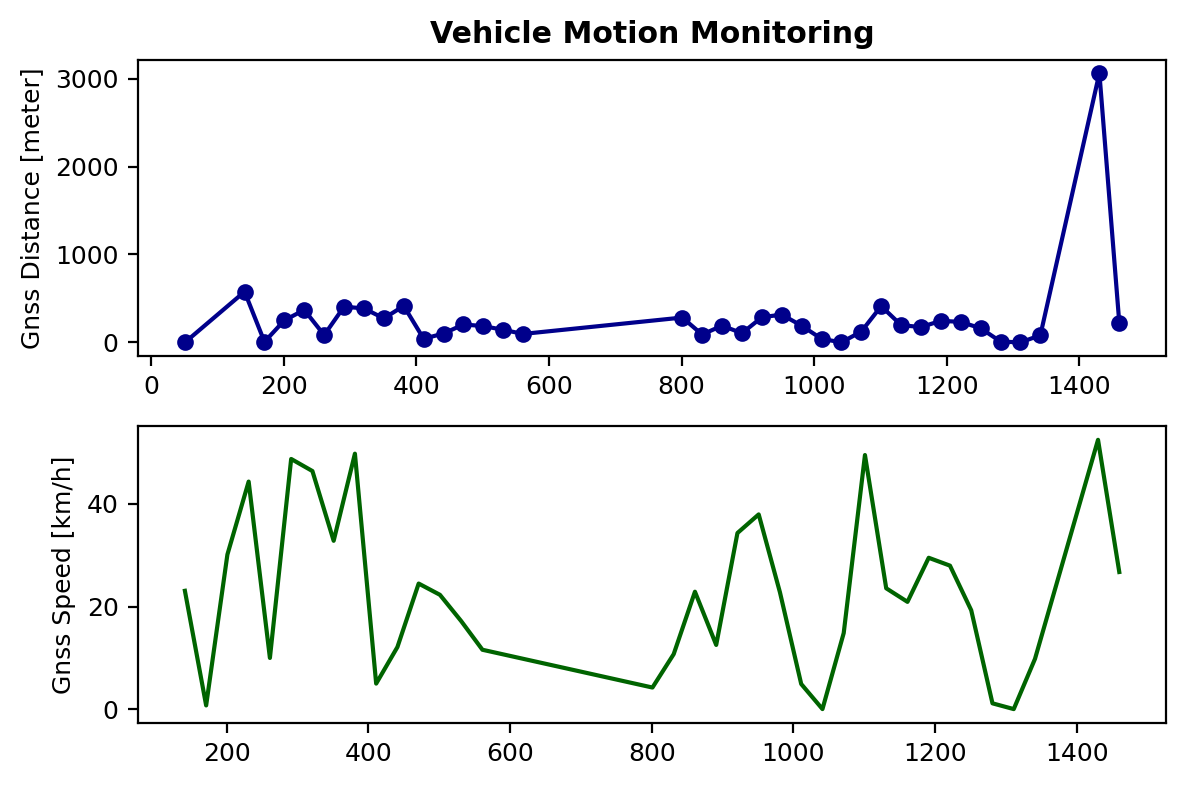

In [414]:
fig, axes = plt.subplots(2, 1)

#auth_pos_df['Travelled [m]'].plot(kind='bar', color='darkblue',ax=axes[0]) #, logy=True

axes[0].set_title('Vehicle Motion Monitoring', fontweight ="bold")

auth_pos_df['Travelled [m]'].plot(kind='line', marker='.', color='darkblue', ms=10,ax=axes[0]) #marker size
auth_pos_df['Velocity [km/h]'].plot(kind='line',color='darkgreen',ax=axes[1])

axes[0].set_ylabel('Gnss Distance [meter]')
axes[1].set_ylabel('Gnss Speed [km/h]')

plt.show()

In [387]:
msg_collection[2][10:13][1000:]
[msg_collection[2][i][6] for i in range(len(msg_collection[2]))][1000:]

[' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality=1',
 ' quality

## Messages to monitor
Parameters to measure according to EUR-Lex - 32021R1228 - EN



1.   Automatic Gain Control (AGC) from - MON-RF
2.   (Average) Carrier to noise (CNO) from - RXM-RAWX
3.   Pseudorange and doppler measurement consistency from - RXM-RAWX
4.   RAIM status from - NMEA-Standard-GBS
5.   Position and velocity consistency from - NAV-PVT
6.   Time from: rcvToW from RXM-RAWX; galTow (Gallileo) and iTOW (gps) from UBX-NAV-TIMEGAL; iTOW, other estimates from NAV-CLOCK





In [90]:
# Message type, parameter index
p_map = [(11,2),(11,6),(11,-1),(6,11),(6,25),(6,12),(6,5),(13,11),(8,2),(12,1),(2,1),(2,2),(2,4),(2,9)] # (11,-1) Tacc, awkward format
raw_metrics = []
for loc in p_map:
    # Extract raw param from message collection
    raw_param = [msg_collection[loc[0]][i][loc[1]] for i in range(len(msg_collection[loc[0]]))]
    #raw_param = raw_param[80:]
    # Convert to float value
    #raw_param = [float(raw_param[i].split('=')[1]) for i in range(len(raw_param))]
    # Add to parsed metrics
    raw_metrics.append(raw_param)
[galTOW, galTOW_valid, Tacc, AGC_L1, AGC_L5, jam_ind, jam_state, spoof_state,
 iTOW_bias, rcvToW, pos_time, lat_pos, lon_pos, alt_pos
 ] = raw_metrics

In [ ]:

data_metrics = [AGC_L1,jam_ind,jam_state,spoof_state,iTOW_bias,rcvToW]
parsed_metrics = []
for metric in data_metrics:
  #metric = metric[80:]
  metric_data = [float(metric[i].split('=')[1]) for i in range(len(metric))]
  #metric_data = metric[i].split('=')[1]
  parsed_metrics.append(metric_data)
  print(metric_data[-1])
  y_axis= metric[0].split('=')[0]
  fig = plt.figure(dpi=150)
  ax = fig.add_subplot(1, 1, 1) 
  plt.rcParams['figure.dpi'] = 200
  font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 9}
  plt.rc('font', **font)
  ax.plot(metric_data)
  ax.set_title('Signal performance metric:'+y_axis, fontweight ="bold")
  ax.set_xlabel('Time [sec]')
  ax.set_ylabel(y_axis)
  if y_axis == " clkB":
    y_range= [-1500000,1500000]
    ax.set_ylim(y_range)
  plt.show()

#fix clock bias over/underflow
clkbias=np.array(parsed_metrics[4])
clkbias[clkbias > 1e6] = 1e6
clkbias[clkbias < -1e6] = -1e6
parsed_metrics[4] = list(clkbias)

In [ ]:
# 4. 
# Most likely failed satellite: 
svid_fail = [msg_collection[1][i][5] for i in range(len(msg_collection[1]))]
#Get stdv of bias [8], and bias [7]
bias = [msg_collection[1][i][7] for i in range(len(msg_collection[1]))]
bias_stddev = [msg_collection[1][i][7] for i in range(len(msg_collection[1]))]
# Constellation
raim_systemID = [msg_collection[1][i][-2] for i in range(len(msg_collection[1]))]
svid_fail

## U-blox Spetrum analyzer

pga=48


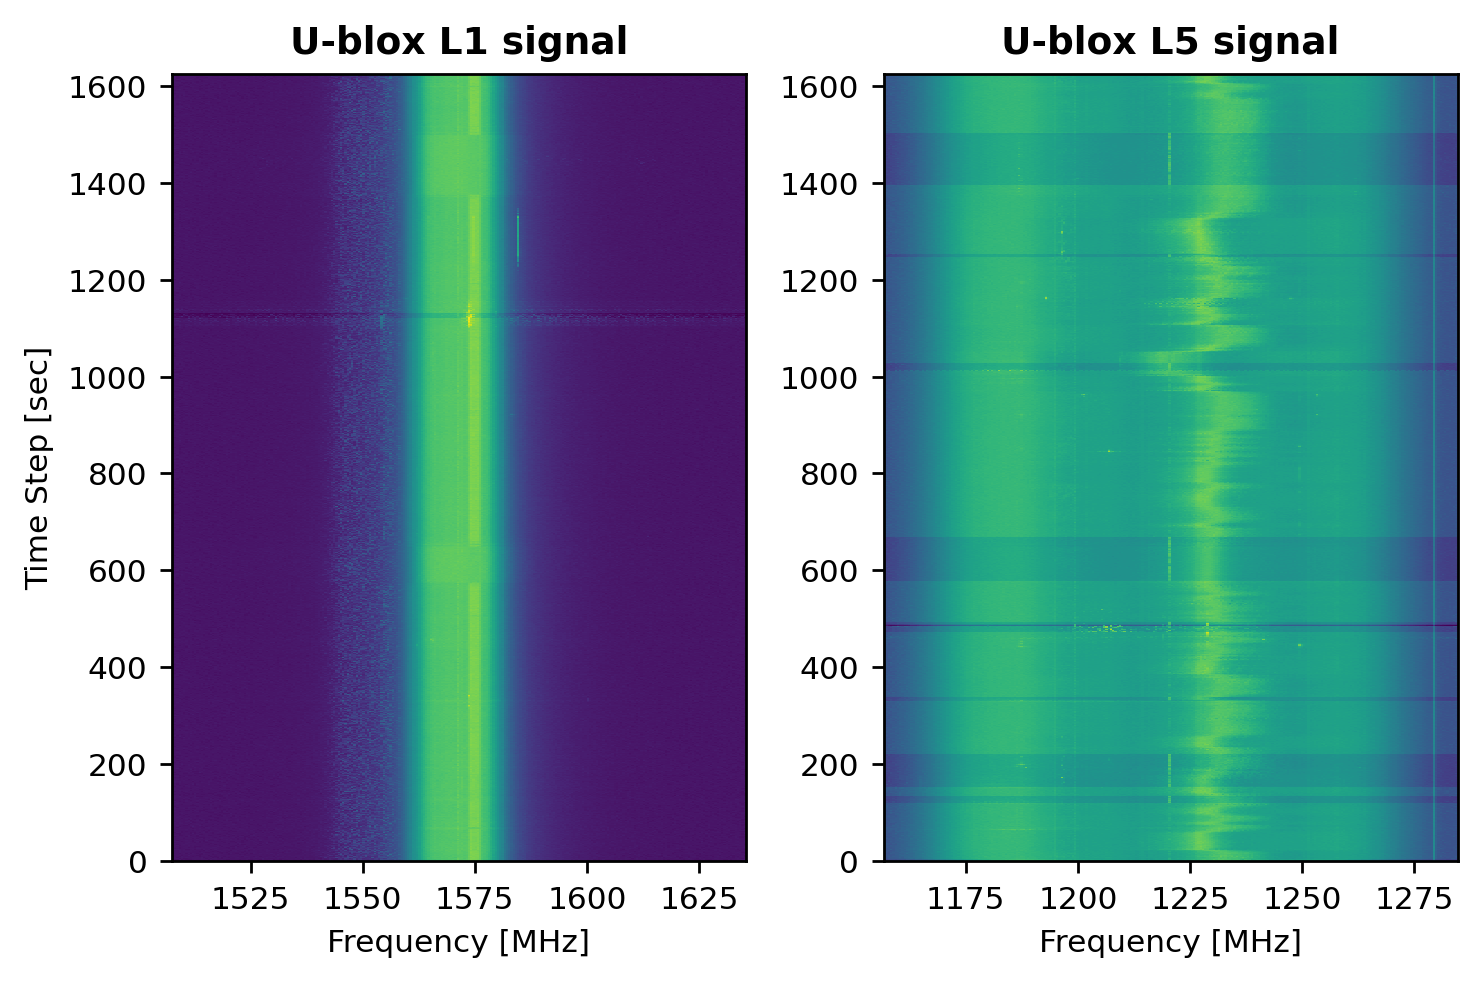

In [415]:
def fix_spectrum_format(spectrum):
  spectrum=''.join(spectrum)
  spectrum=spectrum.split('=')
  # Fix formating of spectrum array
  row=spectrum[0].split(' ')
  spectrum[0]=row[1]
  row=spectrum[1].split(' ')
  row=row[0:-1]
  row[0]=row[0][1:]
  row[-1]=row[-1][0:-1]
  # Convert span data to numpy array
  spectrum[1]=np.array(row,dtype=int)
  parameter = ['span','res','center','pga']
  for i in range(len(spectrum[2:-1])):
    value=spectrum[i+2].split(' ')[0]
    spectrum[i+2] = parameter[i]+'='+str(value)
  return spectrum

# Extract spectrum from MON-SPAN
processed_span_L1=[]
processed_span_L5=[]
for i in range(len(msg_collection[7])):
  spectrum_1=msg_collection[7][i][4:265]
  spectrum_2=msg_collection[7][i][265:]
  # Fix format function
  spectrum_1=fix_spectrum_format(spectrum_1)
  spectrum_2=fix_spectrum_format(spectrum_2)
  # Add to list
  processed_span_L1.append(spectrum_1)
  processed_span_L5.append(spectrum_2)

# Check linear gain
pga_gain= [processed_span_L1[i][5] for i in range(len(processed_span_L1))]
# signal
span_2d_L1= [processed_span_L1[i][1] for i in range(len(processed_span_L1))]
span_2d_L1=np.array(span_2d_L1)
span_2d_L5= [processed_span_L5[i][1] for i in range(len(processed_span_L5))]
span_2d_L5=np.array(span_2d_L5)

plt.rcParams['figure.dpi'] = 250
plt.rcParams["figure.figsize"] = [6.0, 4.0] 
fig, (ax1, ax2) = plt.subplots(1, 2)

# L1 signal parameters
signal_info=processed_span_L1[0]
print(signal_info[5])
span=int(signal_info[2].split('=')[1])/10**6
center=int(signal_info[4].split('=')[1])/10**6
signal_range=[center-span/2,center+span/2]
dx, dy = 0.5, 1
y, x = np.mgrid[slice(0, len(processed_span_L1), dy),
                slice(signal_range[0], signal_range[1], dx)]
L1_x=x             
# Plot L1
ax1.pcolormesh(x,y,span_2d_L1)
ax1.set_title('U-blox L1 signal', fontweight ="bold")
ax1.set_xlabel('Frequency [MHz]')
ax1.set_ylabel('Time Step [sec]')
# L5 signal parameters
signal_info=processed_span_L5[0]
# Span and center in MHz
span=int(signal_info[2].split('=')[1])/10**6
center=int(signal_info[4].split('=')[1])/10**6
signal_range=[center-span/2,center+span/2]
dx, dy = 0.5, 1
y, x = np.mgrid[slice(0, len(processed_span_L5), dy),
                slice(signal_range[0], signal_range[1], dx)]
# Plot L5
ax2.pcolormesh(x,y, span_2d_L5)
ax2.set_title('U-blox L5 signal', fontweight ="bold")
ax2.set_xlabel('Frequency [MHz]')

# Show Plot
plt.show()

In [368]:
#signal_1 = span_2d_L1[306] # spoofed
#signal_2 = span_2d_L1[1124] # observed
#signal_3 = span_2d_L1[900] # normal

#plt.plot(L1_x[0][50:200],signal_1[50:200], alpha=0.5, label = "Lab Spoofing Signal")
#plt.plot(L1_x[0][50:200],signal_2[50:200], alpha=1, label = "Observed Signal")
#plt.plot(L1_x[0][50:200],signal_3[50:200], alpha=0.8, label = "Baseline Signal")

plt.xlabel('Frequency [MHz]')
plt.ylabel('Spectral Density [0-255]')
plt.legend()
plt.show()


NameError: name 'L1_x' is not defined

## Satellite Measurements (RXM - RAWX)

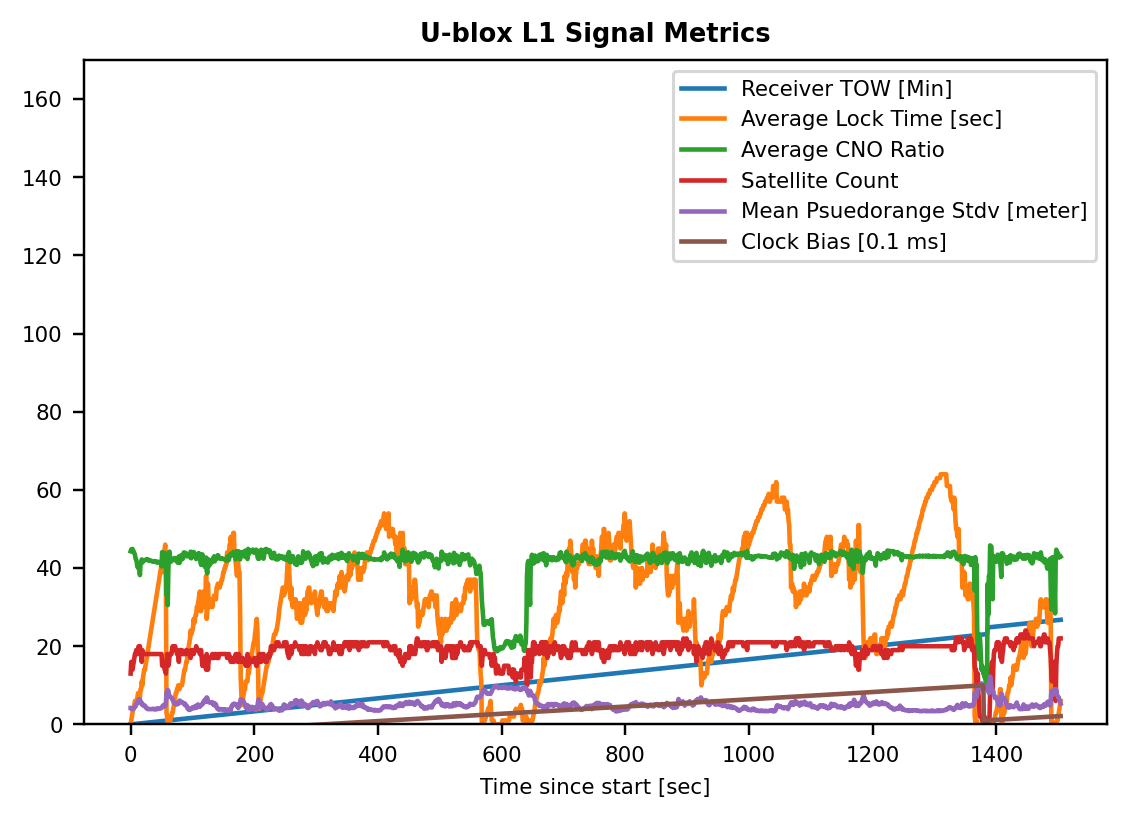

In [ ]:
# Create dataframe to hold all messages
coloum_header= ['run_time','rcTOW','prMes_01', 'cpMes_01', 'doMes_01', 'gnssId_01', 'svId_01', 'reserved2_01',
 'freqId_01', 'locktime_01', 'cno_01', 'prStd_01', 'cpStd_01', 'doStd_01',
 'prValid_01', 'cpValid_01', 'halfCyc_01', 'subHalfCyc_01']
temp_row_list= []
for i in range(len(msg_collection[12])-10):
    [rawx_header,rawx_sats]=signal_process.rawx_struct(msg_collection[12][i])
    # Get msg time
    rcTOW=round(float(rawx_header[1].split('=')[1]))
    # iterate through sat channels
    for sat in rawx_sats:
      # Extract sat parameters
      sat_row = [row.split('=')[1] for row in sat]
      sat_row[:3] = [float(value) for value in sat_row[:3]]
      sat_row[4:] = [int(value) for value in sat_row[4:]]
      sat_row.insert(0,rcTOW)
      sat_row.insert(0,i)
      # Append values to last row
      temp_row_list.append(sat_row)
rawx_df_all=pd.DataFrame(temp_row_list,columns=coloum_header)
# Keep only L1 signals
rawx_df=rawx_df_all[rawx_df_all['reserved2_01']==0].reset_index(drop=True)
# Split by unique sat (constellation, sv_id)
df_split=rawx_df.groupby(['gnssId_01','svId_01'])
group_keys=df_split['gnssId_01'].nunique()
group_keys=list(group_keys.index)

# Create dataframe header for processed metrics
coloum_header= ['Time since start(sec)','Receiver TOW [Min]','Satellite Count','Galileo Count','Average Lock Time [sec]',
                'Average CNO Ratio','Mean Psuedorange Stdv [meter]', 'avg_doStd','Spoof Detect State', 'Clock Bias [0.1 ms]',
                'Jamming Indiator [0-255]', 'Jamming State','L1 Automatic Gain Control [dB]']
# Collect time step statistics
temp_row_list = []
for step in range(len(msg_collection[12])-10):
  # Filter df for all rows matching time step
  rawx_df_step=rawx_df[rawx_df['run_time']==step]
  if not rawx_df_step.empty:
    # Extract Receiver time for time step
    perceived_time = rawx_df_step['rcTOW'].values[0] /60
    # Satellites Connected
    sat_count = len(rawx_df_step)
    # Galileo Satellites Connected
    galileo_count = len(rawx_df_step[rawx_df_step['gnssId_01']=='Galileo'])
    # Average lock duration of connected satellites
    avg_lock_time=round(rawx_df_step['locktime_01'].mean())//1000
    # Average carrier to noise of connected satellites
    avg_CNO=round(rawx_df_step['cno_01'].mean(),1)
    # Standard deviation of pseudo range
    pseudo_std=round(rawx_df_step['prStd_01'].mean(),1)
    # Standard deviation of doppler measurement
    doppler_std=round(rawx_df_step['doStd_01'].mean(),1)
    # Spoof detection state
    spoof_det = parsed_metrics[3][step]
    # clock bias (ms)
    clk_bias = parsed_metrics[4][step] /1e5
    # Jamming indicator
    jam_ind_step = parsed_metrics[1][step]
    # Jam state
    jam_state = abs(parsed_metrics[2][step]-1)*15
    # Automatic gain control (L1)
    agc_L1 = parsed_metrics[0][step] /8191 * 60 +6
    # Assembly row
    time_step_stats = [step, perceived_time,sat_count,galileo_count,avg_lock_time,avg_CNO,pseudo_std,doppler_std,spoof_det,clk_bias,jam_ind_step,jam_state,agc_L1]
    # Add to temp list
    temp_row_list.append(time_step_stats)
rawx_stats=pd.DataFrame(temp_row_list,columns=coloum_header)
rawx_stats["Receiver TOW [Min]"]  = rawx_stats["Receiver TOW [Min]"] - rawx_stats["Receiver TOW [Min]"].min()
# Plot data
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 7}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [6.0, 4.0] 
plt.rcParams['figure.dpi'] = 220
rawx_stats[['Receiver TOW [Min]','Average Lock Time [sec]','Average CNO Ratio','Satellite Count','Mean Psuedorange Stdv [meter]','Clock Bias [0.1 ms]']].plot()
plt.title('U-blox L1 Signal Metrics', fontweight ="bold")
plt.xlabel('Time since start [sec]')
plt.ylim(0,170)
plt.show()

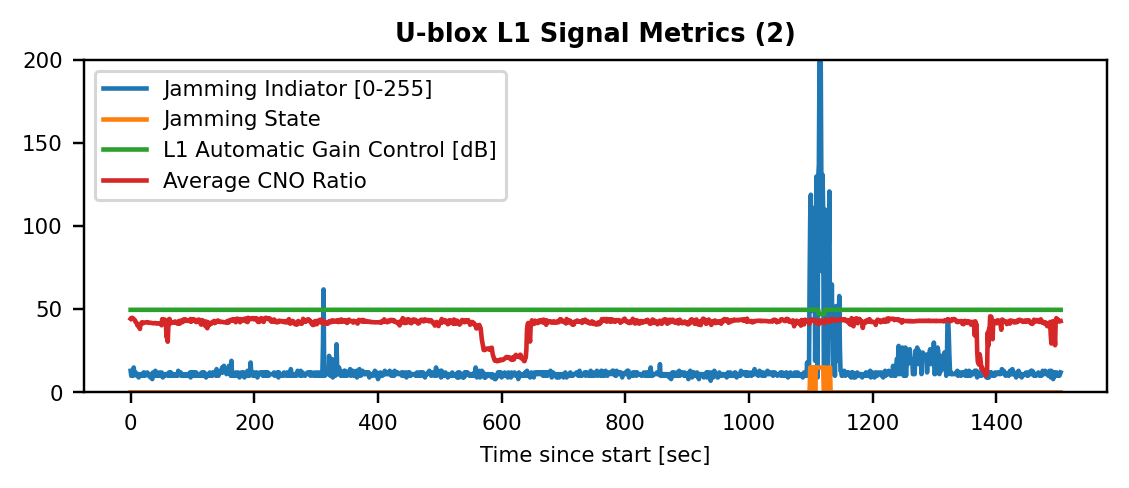

In [ ]:
plt.rcParams["figure.figsize"] = [6, 2] 
rawx_stats[['Jamming Indiator [0-255]', 'Jamming State','L1 Automatic Gain Control [dB]','Average CNO Ratio']].plot()
plt.title('U-blox L1 Signal Metrics (2)', fontweight ="bold")
plt.xlabel('Time since start [sec]')
plt.ylim(0,200)
plt.show()

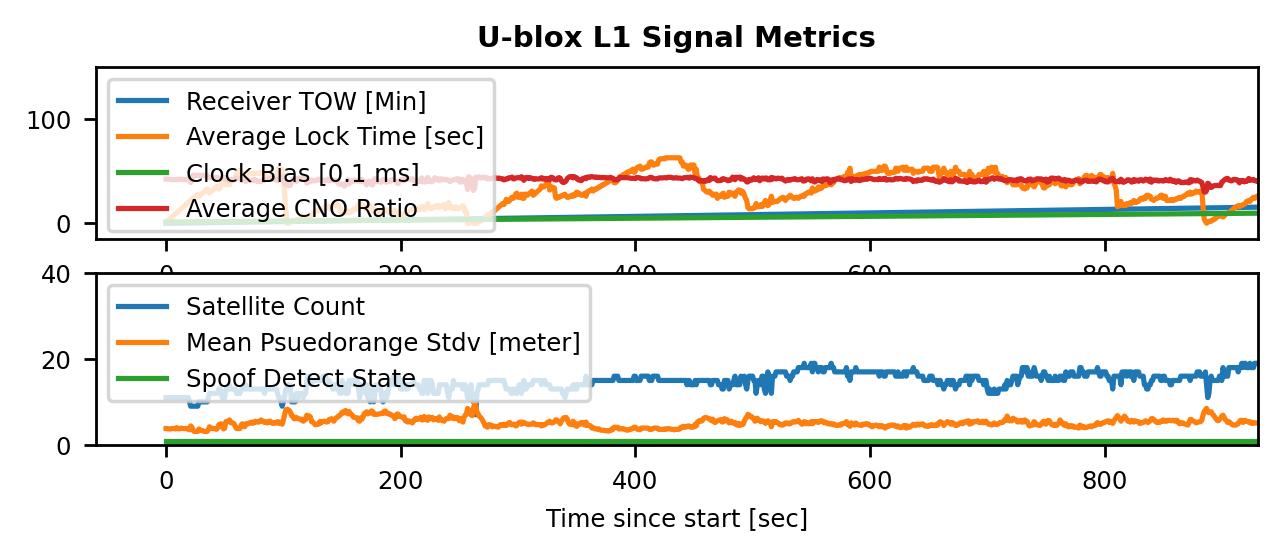

In [ ]:
plt.rcParams['figure.dpi'] = 250

# Plot time data
fig, axes = plt.subplots(2, 1)
rawx_stats[['Receiver TOW [Min]','Average Lock Time [sec]','Clock Bias [0.1 ms]','Average CNO Ratio']].plot(ax = axes[0])
axes[0].set_title('U-blox L1 Signal Metrics', fontweight ="bold")
plt.xlabel('Time since start [sec]')
# Mark spoofing secions
#for i in range(-50,1200,400):
#    axes[0].axvspan(i, i+200, facecolor='r', alpha=0.3)
axes[0].set_xlim(-60,len(msg_collection[12])-60)
axes[0].set_ylim(-15,150)

# Plot meta data
rawx_stats[['Satellite Count','Mean Psuedorange Stdv [meter]','Spoof Detect State']].plot(ax = axes[1])
#plt.title('U-blox L1 Signal Metrics', fontweight ="bold")
plt.xlabel('Time since start [sec]')
# Mark spoofing secions
#for i in range(-50,1200,400):
#    axes[1].axvspan(i, i+200, facecolor='r', alpha=0.3)
axes[1].set_xlim(-60,len(msg_collection[12])-60)
axes[1].set_ylim(0,40)
plt.show()


# SFRBX DATA - OSNMA

## Testing


In [ ]:

folder = 'C:/Users/A413626/Desktop/GNSS_stuff/GNSS_Binary/21-03-2022_data/'

# Iterate through all recorded runs
for run in range(1,50):
  print("\n",run,"\n")
  filename = '{}21-03-2022_{}.csv'.format(folder,str(run))
  msg_collection, mesages= load_data(filename)
  signal_info = signal_process.read_live_data(msg_collection)
  osnma_instance, osnma_results = OSNMA.run_osnma(msg_collection)
  print(signal_info)
  print(osnma_results)


 1 

 [' agcCnt_01=5967', ' agcCnt_01=5967', ' agcCnt_01=5967', ' agcCnt_01=5967', ' agcCnt_01=5967'] 
 [' jamInd_01=10', ' jamInd_01=11', ' jamInd_01=11', ' jamInd_01=10', ' jamInd_01=10']
 [' jammingState_01=1', ' jammingState_01=1', ' jammingState_01=1', ' jammingState_01=1', ' jammingState_01=1']
 [' spoofDetState=1', ' spoofDetState=1', ' spoofDetState=1', ' spoofDetState=1', ' spoofDetState=1']
 [' clkB=871615', ' clkB=870680', ' clkB=869746', ' clkB=868811', ' clkB=867876']
 Time: 141960,  iTOW=15:25:42
 Position: lat=57.709704 lon=11.9456205
 
Average CNO (L1): 34.6
Average Lock duration (L1): 38389.0

Satellites Connected:['GPS, 9', 'Galileo, 8']
 Of which L1/E1: ['GPS, 7', 'Galileo, 4']

Filtering (split): Kept 750/1082 pages, 69.32%
Filtering (osnma): Kept 360/750 pages, 48.00%
Found OSNMA Satellite!
['01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010']
Total Satellite Kept: 1/3

Foun

In [ ]:
segment_id = 5
folder = 'C:/Users/A413626/Desktop/GNSS_stuff/GNSS_Binary/21-03-2022_data/'
filename = '{}21-03-2022_{}.csv'.format(folder,str(segment_id))
msg_collection, mesages= load_data(filename)
signal_info = signal_process.read_live_data(msg_collection)
osnma_instance, osnma_results = OSNMA.run_osnma(msg_collection)
print(signal_info)
print(osnma_results)


 [' agcCnt_01=5265', ' agcCnt_01=5265', ' agcCnt_01=5265', ' agcCnt_01=5265', ' agcCnt_01=5616'] 
 [' jamInd_01=9', ' jamInd_01=7', ' jamInd_01=7', ' jamInd_01=8', ' jamInd_01=11']
 [' jammingState_01=1', ' jammingState_01=1', ' jammingState_01=1', ' jammingState_01=1', ' jammingState_01=1']
 [' spoofDetState=1', ' spoofDetState=1', ' spoofDetState=1', ' spoofDetState=1', ' spoofDetState=1']
 [' clkB=187369', ' clkB=186443', ' clkB=185518', ' clkB=184592', ' clkB=183666']
 Time: 386473,  iTOW=11:20:55
 Position: lat=57.70973133 lon=11.94555167
 
Average CNO (L1): 35.9
Average Lock duration (L1): 46230.0

Satellites Connected:['GPS, 9', 'Galileo, 7']
 Of which L1/E1: ['GPS, 9', 'Galileo, 7']

Filtering (split): Kept 2400/3948 pages, 60.79%
Filtering (osnma): Kept 1920/2400 pages, 80.00%
Found OSNMA Satellite!
['01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010', '01010010']

In [ ]:
import timeit
# Start timer
timing=np.empty(0)
start = timeit.default_timer()
runs=1000
for j in range(runs):
  osnma_instance.auth_tag(1,5)
# End timer
stop = timeit.default_timer()
execution_time = stop - start
timing=np.append(timing,execution_time)
execution_time=np.mean(timing)
print('The time taken is {}s '.format(execution_time/runs))

The time taken is 0.005529169299989007s 


## Time mangement




Time Handler ran for 514 Seconds
Total NTP requests: 2
Valid OSNMA sub-frames: 4
GNSS Sync uptime: 23.3%



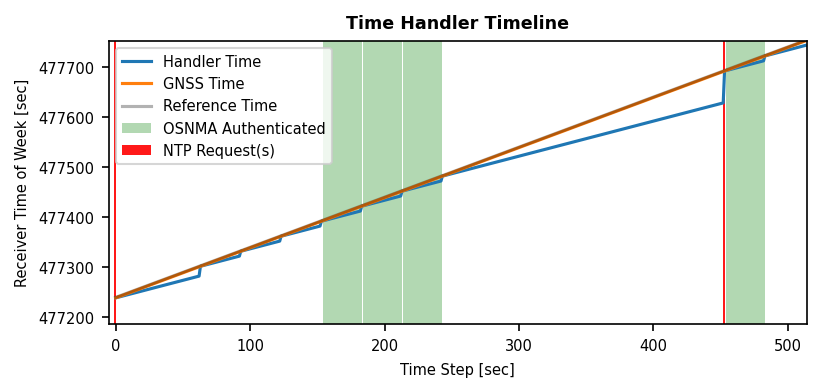

In [ ]:
osnma_duration = osnma_instance.get_duration()[0]
time_instance, df, time_info,time_fig = time_mangement.run_time(osnma_instance,msg_collection,max_dur=osnma_duration,plot=True)
print(time_info)
plt.show()

In [ ]:
df_sampled= df.iloc[::5, :]
for i in range(0,len(df_sampled),50):
  display(df_sampled[i:i+50])

## Warm OSNMA - Time to first fix (authenticated)

Rough calculation time (3000 messages)

*   49 ms, process_Pages(msg_collection,3000) - process u-blox data, format to pandas dataframe, filter out OSNMA data
*   4 ms, authenticate_DS(msg_hex,public_key_hex,signature_hex) - ECDSA authentcation
*   80 ms, OSNMA(msg_collection) - Process data, locate root key and do ECDSA authentcation

*   0.6 ms, osnma_instance.auth_chain(0,1) - authentcate chain key with id age 165, perform 165 sha-256 hashes
*   0.5 ms, osnma_instance.auth_tag(0,1) - authentcate tag by locating subframes and performing HMAC authentication 



In [ ]:
def hot_start_valid(osnma_instance,tag_auth=True): 
  for index in range(osnma_instance.osnma_sat_count):
    sat_prn, sub_count = osnma_instance.get_OSNMA_prn(index)
    for i in range(1,sub_count):
      # Authenticate sub-frame
      try:
        chain_ok=osnma_instance.auth_chain(index,i)
        if tag_auth:
          tag_ok = osnma_instance.auth_tag(index,i)
        else: tag_ok = True
        if chain_ok and tag_ok:
          return True
      except: continue
  return False

folder = 'C:/Users/A413626/Desktop/GNSS_stuff/GNSS_Binary/21-03-2022_data/'
# Resolution around 10 seconds
start_time = []
max_msg = 2500
# Iterate through all recorded runs
for run in range(50):
  filename = '{}21-03-2022_{}.csv'.format(folder,str(run))
  msg_collection, mesages= load_data(filename)
  # Attempt to get root key with fewest messages
  for msg_count in range(500,max_msg,50):
    osnma_instance = OSNMA(msg_collection,msg_count)
    # Check if root key is found
    if osnma_instance.data_good and osnma_instance.kroot_good:
        # Record duration
        warm_fix_time = osnma_instance.get_duration()[0]
        # Attempt to get hot start fix with fewest messages
        for min_msg in range(200,max_msg//2,50):
         osnma_instance.process_Pages(msg_collection,min_msg)
         # Proceed if data is good
         if osnma_instance.data_good:
           if hot_start_valid(osnma_instance,tag_auth=True):
             # Record hot fix time and exit
             hot_fix_time = osnma_instance.get_duration()[0]
             break
        gal_sats=len(osnma_instance.PRN_pages)
        gal_sats_OSMA=len(osnma_instance.sats_OSNMA_df)
        # Add fix times and exit
        start_time.append([warm_fix_time,hot_fix_time,gal_sats,gal_sats_OSMA])
        break
  # If no root key is found add time as 0,0
  if not osnma_instance.kroot_good:
    start_time.append([0,0,gal_sats,gal_sats_OSMA])
df =pd.DataFrame(start_time,columns=["Warm Start","Hot Start","Galileo Satellites","Transmitting OSNMA"])
df.to_csv("21-03-2022_fix_times_updated")
df

In [ ]:
# Plot data

fig, axes = plt.subplots(1, 1)

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 7}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 220
df[["Warm Start","Hot Start"]].plot(ax = axes,style='.-')
plt.title('OSNMA Authentication Time', fontweight ="bold")
plt.xlabel('Run Segment')
plt.ylabel('The Time To First Fix (TTFF)')
for i in range(2,50,20):
    axes.axvspan(i, i+10, facecolor='g', alpha=0.3)
plt.ylim(0,400)
plt.show()

In [ ]:
# Plot time data
fig, axes = plt.subplots(2, 1)
df[["Warm Start","Hot Start"]].plot(ax = axes[0])
axes[0].set_title('OSNMA Authentication Time', fontweight ="bold")
plt.xlabel('Run Segment')
axes[0].set_ylabel('The Time To First Fix (TTFF)')
# Mark spoofing secions
for i in range(2,50,20):
    axes[0].axvspan(i, i+10, facecolor='g', alpha=0.3)
axes[0].set_ylim(0,430)

# Plot meta data
df[["Galileo Satellites","Transmitting OSNMA"]].plot(ax = axes[1])
#plt.title('U-blox L1 Signal Metrics', fontweight ="bold")
plt.ylabel('Satellite Connected')
# Mark spoofing secions
for i in range(2,50,20):
    axes[1].axvspan(i, i+10, facecolor='g', alpha=0.3)
plt.ylim(0,10)
fig.patch.set_alpha(1)
plt.show()